### Network Analysis

In [43]:
import pandas as pd
from collections import defaultdict
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
X = pd.read_csv("../../lca_data.csv")
y = pd.read_csv("../../subgroups.csv")["reassigned_classes"]

In [13]:
try:
    X = X.drop(columns=["Unnamed: 0"])
except: pass
X['class'] = y
X.head()

,gender,age_group,admission_type,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,...,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,class
0,1,45-64,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,0,16-24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
2,0,45-64,1,1,1,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,5
3,0,25-44,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1,65-84,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [41]:
def generate_network(class_num, X):
    class_data = X[X['class'] == class_num]
    total_patients = len(class_data)
    morbidity_frequency = defaultdict(int)
    
    for i in range(len(class_data)):
        for j in range(3, len(class_data.columns)):
            if class_data.iloc[i][class_data.columns[j]] == 1:
                morbidity_frequency[class_data.columns[j]] += 1
                
    cooccurrence_matrix = pd.DataFrame(0, index=morbidity_frequency.keys(), columns=morbidity_frequency.keys())
    combos = list(combinations(morbidity_frequency.keys(), 2))
    
    # Building up the cooccurrence matrix
    for i in range(len(class_data)):
        for j in range(len(combos)):
            if class_data.iloc[i][combos[j][0]] == 1 and class_data.iloc[i][combos[j][1]] == 1:
                cooccurrence_matrix.loc[combos[j][0], combos[j][1]] += 1
                cooccurrence_matrix.loc[combos[j][1], combos[j][0]] += 1
    
    # normalize the cooccurrence matrix by dividing by the total number of patients
    for i in range(len(cooccurrence_matrix)):
        for j in range(len(cooccurrence_matrix)):
            cooccurrence_matrix.iloc[i, j] = cooccurrence_matrix.iloc[i, j] / total_patients
    
    # Create network where node size is proportional to the frequency of the morbidity and edge width is proportional to the cooccurrence frequency
    G = nx.Graph()
    for i in range(len(morbidity_frequency)):
        G.add_node(list(morbidity_frequency.keys())[i], size=morbidity_frequency[list(morbidity_frequency.keys())[i]])
        
    for i in range(len(cooccurrence_matrix)):
        for j in range(len(cooccurrence_matrix)):
            if cooccurrence_matrix.iloc[i, j] > 0.3:
                G.add_edge(cooccurrence_matrix.index[i], cooccurrence_matrix.columns[j], weight=cooccurrence_matrix.iloc[i, j])
                
    return G 

In [46]:
G = generate_network(1, X)

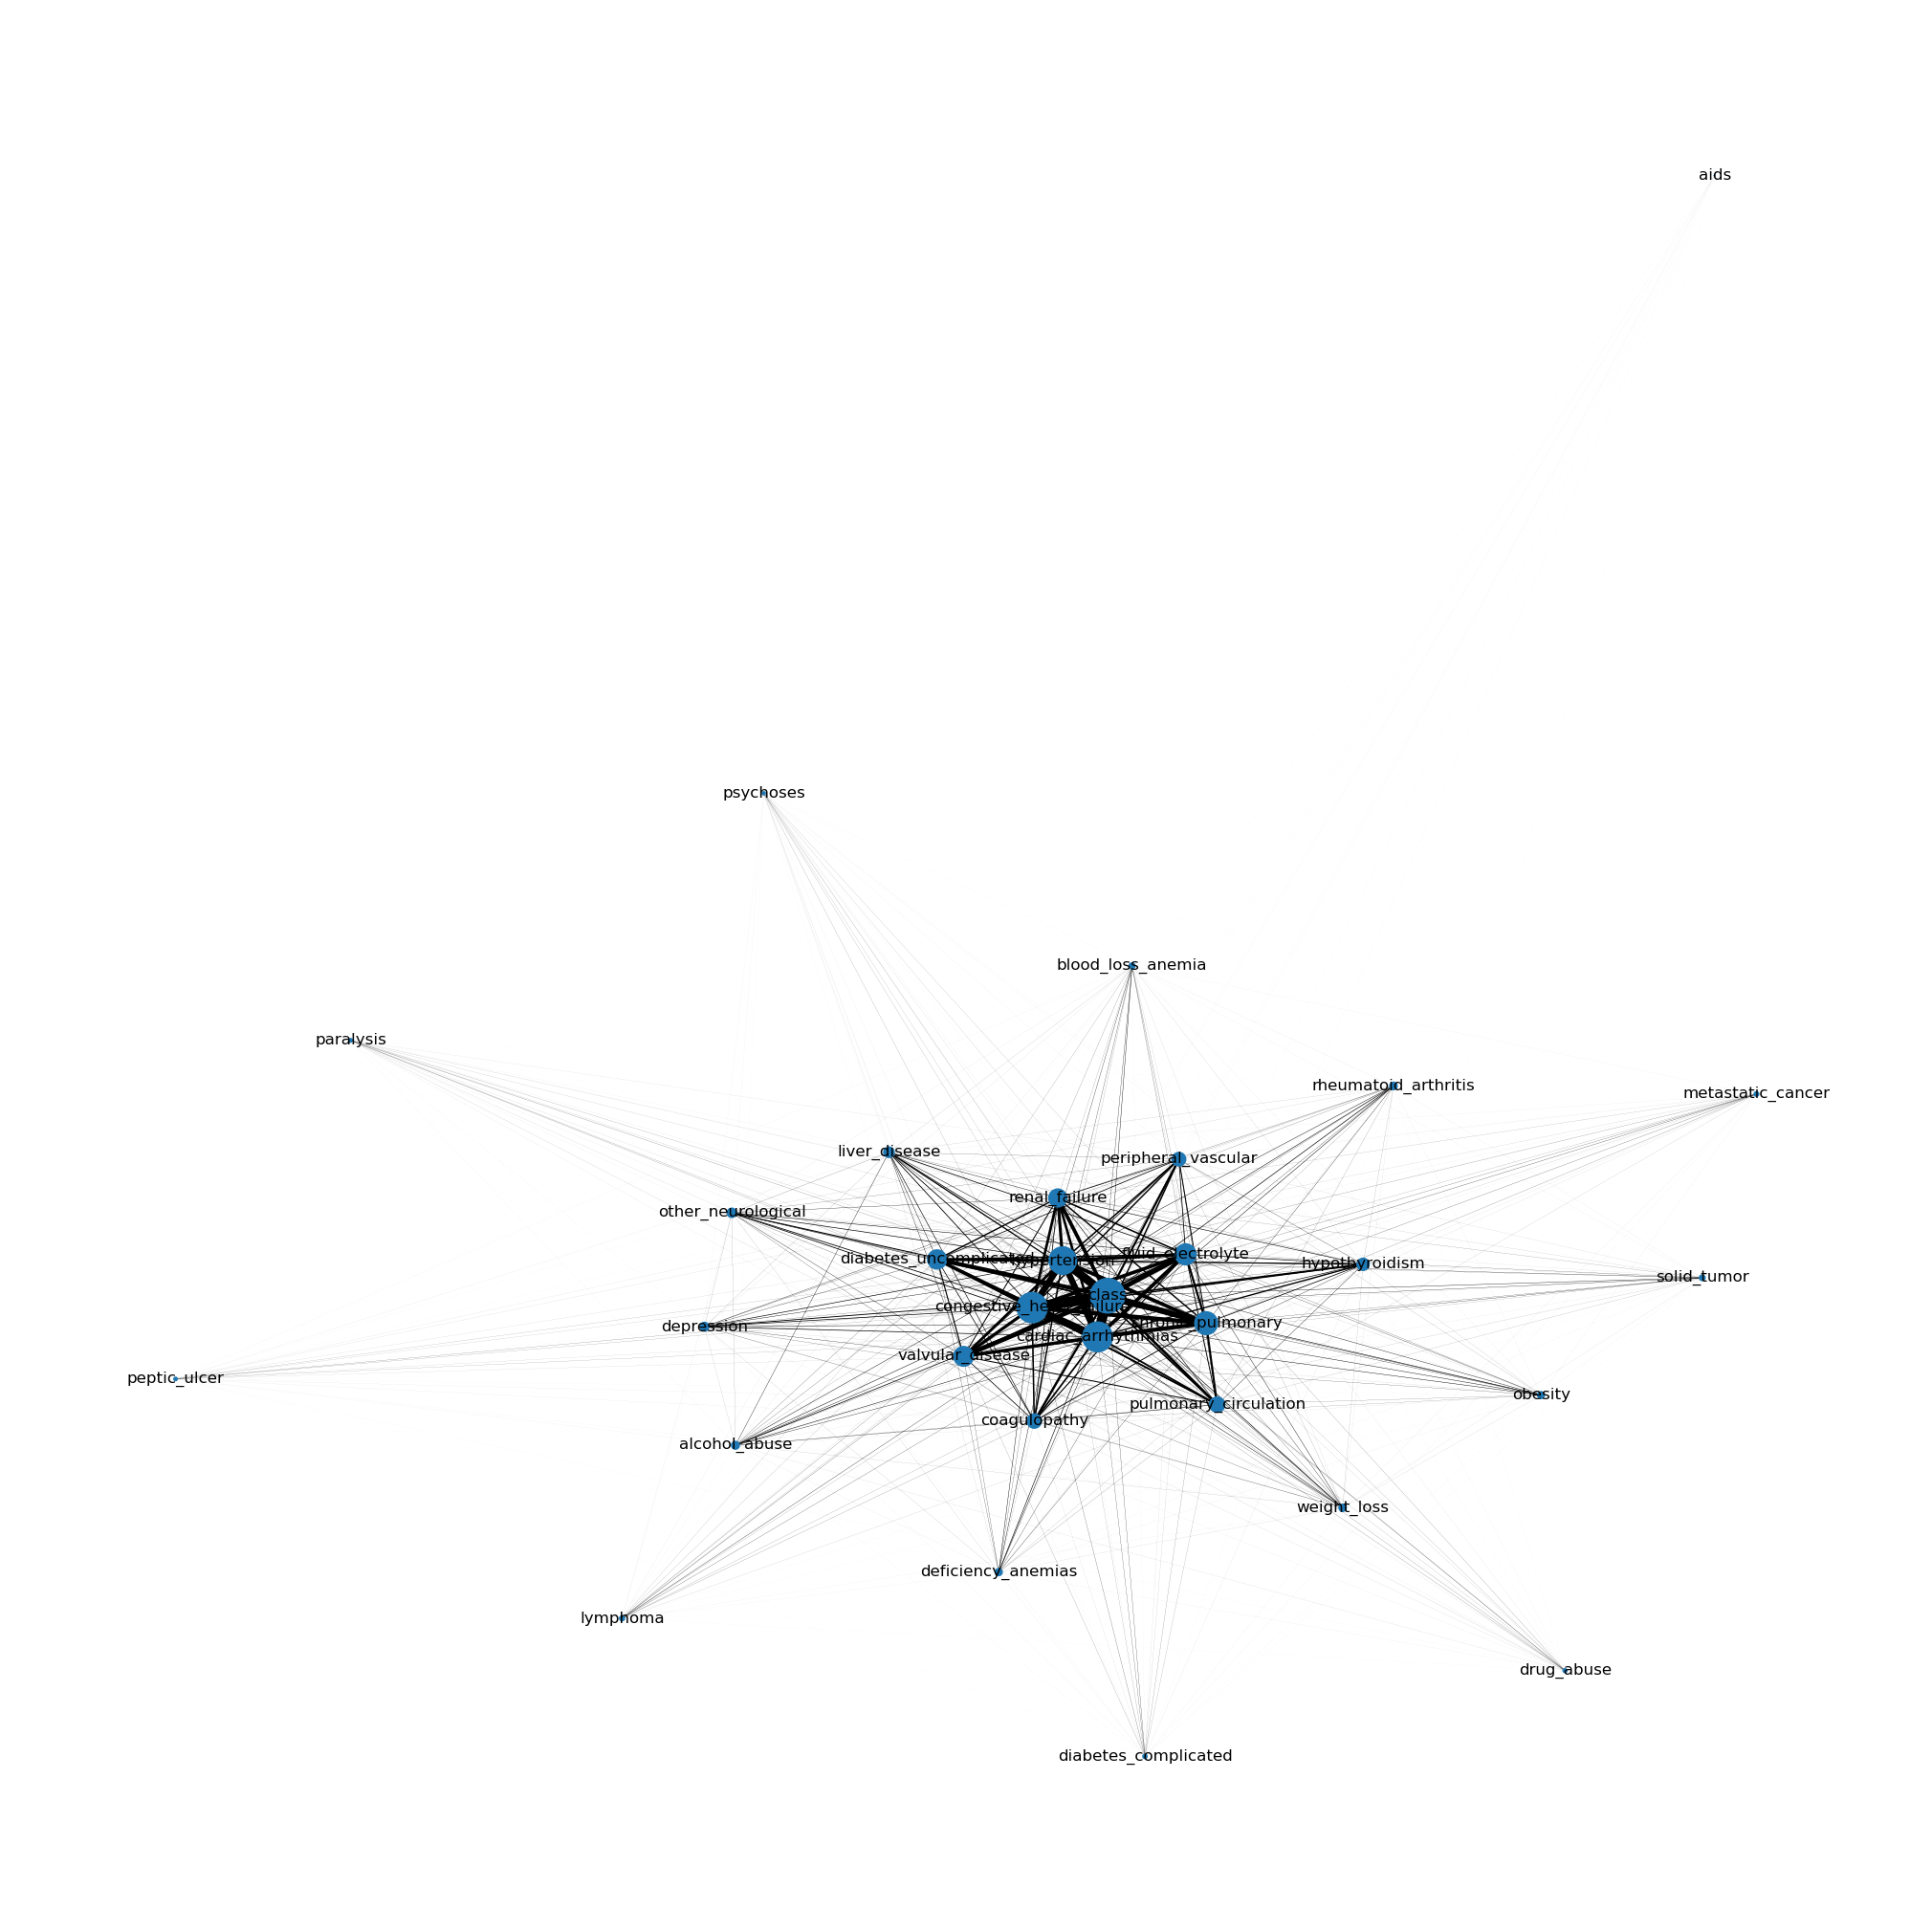

In [54]:
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=[G.nodes[n]['size']*0.1 for n in G], width=[G[u][v]['weight']*10 for u, v in G.edges])